In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# get nltk data
nltk.download('stopwords')
nltk.download('wordnet')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jiss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jiss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load dataset
news_df = pd.read_json('datasets_repo/News_Category_Dataset.json', lines=True)
news_df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [3]:
# print unique categories
print(news_df.category.unique())


['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS']


In [4]:
# combining some raw data categories that are very close
news_df.category = news_df.category.map(
    lambda x: "WORLD" if x == "WORLDPOST" or x == "THE WORLDPOST" or x == 'WORLD NEWS' else x)
news_df.category = news_df.category.map(
    lambda y: "ARTS & CULTURE" if y == "ARTS" or y == "ARTS & CULTURE" else y)
news_df.category = news_df.category.map(
    lambda z: "EDUCATION" if z == "EDUCATION" or z == "COLLEGE" else z)
news_df.category = news_df.category.map(
    lambda d: "HEALTH" if d == "HEALTHY LIVING" else d)

# removing rows with description size less than 20
mask = news_df['short_description'].str.len() > 20
news_df = news_df.loc[mask]
# combines headline and short_description for the input
news_df['text'] = news_df.headline+" "+news_df.short_description
# replace empty values with NaN
news_df = news_df.replace("", np.NaN)
# drop rows with value as NaN
news_df.dropna(axis=0, inplace=True)

In [5]:
# removing symbols,digits,stopwords from text and lemmatizing each words in the text.
import re
symbols_dt = re.compile('[/(){}\[\]\|@,;]')
symbols_dt2 = re.compile('[^0-9a-z +_]')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = symbols_dt.sub(' ', text)  # remove symbols in text data
    text = symbols_dt2.sub('', text)
    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return text


news_df['text'] = news_df['text'].apply(clean_text)
news_df['text'] = news_df['text'].str.replace('\d+', '')

In [6]:
# here v represents each category as an integer in the category_id column.
from io import StringIO
col = ['category', 'text']
# news_df = news_df.reindex(columns=col)


news_df = news_df[col]
news_df = news_df[pd.notnull(news_df['text'])]

news_df.columns = ['category', 'text']
news_df['category_id'] = news_df['category'].factorize()[0]
category_id_df = news_df[['category', 'category_id']
                         ].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
# print(category_to_id)
news_df.head()

,category,text,category_id
0,CRIME,mass shooting texas last week tv left husban...,0
1,ENTERTAINMENT,smith join diplo nicky jam world cup official...,1
2,ENTERTAINMENT,hugh grant marries first time age actor longt...,1
3,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,1
4,ENTERTAINMENT,julianna margulies us donald trump poop bag pi...,1


In [7]:
# set category column as an index
news_df = news_df.set_index("category")
news_df

,text,category_id
category,,
CRIME,mass shooting texas last week tv left husban...,0
ENTERTAINMENT,smith join diplo nicky jam world cup official...,1
ENTERTAINMENT,hugh grant marries first time age actor longt...,1
ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,1
ENTERTAINMENT,julianna margulies us donald trump poop bag pi...,1
ENTERTAINMENT,morgan freeman devastated sexual harassment cl...,1
ENTERTAINMENT,donald trump lovin new mcdonalds jingle tonigh...,1
ENTERTAINMENT,watch amazon prime thats new week there great ...,1
ENTERTAINMENT,mike myers reveals hed like fourth austin powe...,1


In [8]:
# drop some categories
news_df = news_df.drop(['IMPACT', 'QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES', 'FIFTY',
                        'WEIRD NEWS', 'ENTERTAINMENT', 'GREEN', 'GOOD NEWS', 'COMEDY', 'PARENTS', 'WOMEN',
                        'POLITICS', 'MEDIA'], axis=0)
news_df = news_df.replace("", np.NaN)
# drop rows with value as NaN
news_df.dropna(axis=0, inplace=True)

In [9]:
# reset the index,
news_df = news_df.reset_index("category")
news_df

,category,text,category_id
0,CRIME,mass shooting texas last week tv left husban...,0
1,WORLD,north korea still open talk trump cancel summi...,5
2,WORLD,thousand travel home ireland vote abortion acc...,5
3,CRIME,rachel dolezal face felony charge welfare frau...,0
4,CRIME,man face charge pulling knife stun gun muslim ...,0
5,CRIME,people injured indiana school shooting male s...,0
6,WORLD,trump suggests north korea summit could still ...,5
7,WORLD,north korea threatens call trump summit warns ...,5
8,WORLD,investigation find russian missile shot flight...,5
9,WORLD,kim jong un baited trump canceling north korea...,5


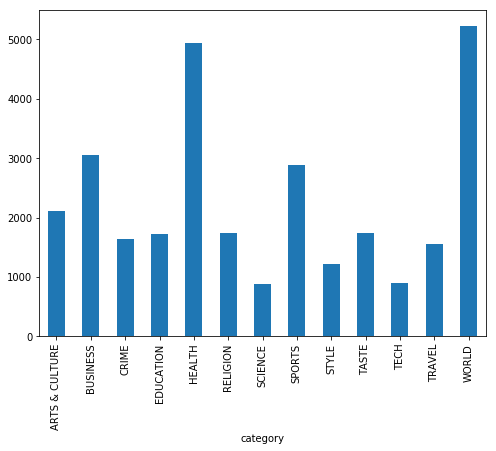

In [10]:
# ploting each category and corresponding no of samples - bar chart
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
news_df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [11]:
# to get the info about our preprocessed news dataframe
news_df.category.value_counts()

WORLD             5230
HEALTH            4941
BUSINESS          3059
SPORTS            2891
ARTS & CULTURE    2117
RELIGION          1738
TASTE             1735
EDUCATION         1731
CRIME             1643
TRAVEL            1555
STYLE             1221
TECH               899
SCIENCE            879
Name: category, dtype: int64

**Extracting feaure vectors**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
d = news_df["text"].__iter__()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(d)
labels = news_df.category_id
features.shape

(29639, 16530)

In [13]:
category_id_df = news_df[['category', 'category_id']
                         ].sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)

{'CRIME': 0, 'WORLD': 5, 'SPORTS': 10, 'BUSINESS': 11, 'TRAVEL': 12, 'TECH': 14, 'RELIGION': 15, 'SCIENCE': 17, 'EDUCATION': 18, 'ARTS & CULTURE': 20, 'STYLE': 21, 'TASTE': 23, 'HEALTH': 24}


**Unigrams and Bigrams**

In [14]:
from sklearn.feature_selection import chi2
N = 2
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print(f"{category}")
    nwline = '\n. '
    print(f"correlated unigrams:{nwline}{nwline.join(unigrams[-N:])}")
    print(f"correlated bigrams:{nwline}{nwline.join(bigrams[-N:])}")

ARTS & CULTURE
correlated unigrams:
. artist
. art
correlated bigrams:
. stage door
. first nighter
BUSINESS
correlated unigrams:
. company
. business
correlated bigrams:
. business qa
. woman business
CRIME
correlated unigrams:
. cop
. police
correlated bigrams:
. police said
. police say
EDUCATION
correlated unigrams:
. college
. student
correlated bigrams:
. college student
. higher education
HEALTH
correlated unigrams:
. cancer
. health
correlated bigrams:
. mental health
. gps guide
RELIGION
correlated unigrams:
. pope
. christian
correlated bigrams:
. meditation prayer
. daily meditation
SCIENCE
correlated unigrams:
. nasa
. scientist
correlated bigrams:
. scientist say
. solar system
SPORTS
correlated unigrams:
. player
. nfl
correlated bigrams:
. lebron james
. super bowl
STYLE
correlated unigrams:
. hair
. fashion
correlated bigrams:
. red carpet
. fashion week
TASTE
correlated unigrams:
. delicious
. recipe
correlated bigrams:
. ice cream
. cooking cuff
TECH
correlated unigra

In [15]:
# train the classifier
# Naive Bayes Classifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(news_df['text'],
                                                    news_df['category'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
# print(clf)

**Make Predictions**

In [16]:
print(clf.predict(count_vect.transform([
    "Instagram updating content-banning policies on app"
])))

['TECH']


In [17]:
print(clf.predict(count_vect.transform([
    "Climate change poses mental health risks to children and teens"
])))

['HEALTH']


In [18]:
print(clf.predict(count_vect.transform([
    "NASA scientist defends use of NUCLEAR weapons on asteroid"
])))

['SCIENCE']


In [19]:
print(clf.predict(count_vect.transform([
    """A ‘Haunted’ Hotel in Colorado Is Reopening With an Even Creepier Vibe  
    """
]
)))

['TRAVEL']


In [20]:
print(clf.predict(count_vect.transform([

    "Champions League Final: Gary Lineker backs Liverpool to beat Tottenham in Madrid"

])))

['SPORTS']


**Wrong Predicion**

Should be predicted as category 'RELIGION', but predicted under 'WORLD'

In [21]:
print(clf.predict(count_vect.transform([

    "For many Muslims, Ramadan is a built-in digital detox program"

])))

['WORLD']


**Build models**

In [22]:
# using LinearSVC
from sklearn.svm import LinearSVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, news_df.index, test_size=0.33, random_state=0
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
# classification report showing model evaluation metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
print(metrics.classification_report(y_test, y_pred,
                                    target_names=news_df['category'].unique()))
print('accuracy %s' % accuracy_score(y_pred, y_test))

                precision    recall  f1-score   support

         CRIME       0.77      0.76      0.76       547
         WORLD       0.80      0.83      0.81      1701
        SPORTS       0.83      0.85      0.84       961
      BUSINESS       0.67      0.68      0.68       981
        TRAVEL       0.69      0.69      0.69       495
          TECH       0.67      0.48      0.56       307
      RELIGION       0.73      0.66      0.69       570
       SCIENCE       0.66      0.47      0.55       286
     EDUCATION       0.78      0.70      0.74       589
ARTS & CULTURE       0.72      0.72      0.72       695
         STYLE       0.72      0.67      0.70       405
         TASTE       0.74      0.78      0.76       555
        HEALTH       0.72      0.80      0.76      1689

     micro avg       0.74      0.74      0.74      9781
     macro avg       0.73      0.70      0.71      9781
  weighted avg       0.74      0.74      0.74      9781

accuracy 0.7437889786320417


In [24]:
# using multinomialNB
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, news_df.index, test_size=0.33, random_state=0
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print(metrics.classification_report(y_test, y_pred,
                                    target_names=news_df['category'].unique()))
print('accuracy %s' % accuracy_score(y_pred, y_test))

                precision    recall  f1-score   support

         CRIME       0.90      0.50      0.65       547
         WORLD       0.56      0.92      0.70      1701
        SPORTS       0.85      0.77      0.81       961
      BUSINESS       0.63      0.58      0.60       981
        TRAVEL       0.90      0.29      0.44       495
          TECH       1.00      0.02      0.04       307
      RELIGION       0.92      0.23      0.37       570
       SCIENCE       1.00      0.08      0.15       286
     EDUCATION       0.90      0.30      0.45       589
ARTS & CULTURE       0.84      0.45      0.58       695
         STYLE       0.96      0.29      0.44       405
         TASTE       0.89      0.52      0.66       555
        HEALTH       0.45      0.95      0.61      1689

     micro avg       0.61      0.61      0.61      9781
     macro avg       0.83      0.45      0.50      9781
  weighted avg       0.74      0.61      0.58      9781

accuracy 0.6080155403332993
